In [171]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# Import English using en_core_web_sm.load()
import spacy
import en_core_web_sm
import html
import re
# Import matplotlib and wordcloud 
import matplotlib.pyplot as plt
import wordcloud
from spacy import displacy

In [172]:
nlp = en_core_web_sm.load()

In [173]:
data = pd.read_csv('./drive/MyDrive/Colab Notebooks/deep-learning/train.csv')
test_data = pd.read_csv('./drive/MyDrive/Colab Notebooks/deep-learning/test.csv')

In [174]:
data.sample(5)


,id,keyword,location,text,target
6753,9674,tornado,"Asheville, NC",I liked a @YouTube video http://t.co/itnKBxgWLH Lexi Belle for Oklahoma tornado victims,1
7357,10534,wildfire,"Bakersfield, California",#California #wildfire destroys more homes but crews advance. http://t.co/2PPzGpxybi http://t.co/dS9khKffwc,1
4196,5959,hazard,"Pleasanton, CA",Choking Hazard Prompts Recall Of Kraft Cheese Singles http://t.co/XGKyVF9t4f,0
2215,3172,deluge,518,@theburnageblue yes man i was having a bad week so far but Events + a deluge of favs have turned it right around,0
6976,10006,tsunami,NaN,@Eric_Tsunami worry about yourself,0


Missing values

In [175]:
data.isnull().sum()*100/data.shape[0]

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [195]:
keywords = data.keyword.value_counts(ascending=False).reset_index()
keywords[0:15]

,index,keyword
0,fatalities,45
1,armageddon,42
2,deluge,42
3,damage,41
4,body%20bags,41
5,harm,41
6,sinking,41
7,fear,40
8,outbreak,40
9,evacuate,40


In [197]:
textos = data[data['keyword'].notna()].iloc[25:30, [1,3]]
for t in textos.values:
    print(t)

['ablaze'
 'TRUCK ABLAZE : R21. VOORTREKKER AVE. OUTSIDE OR TAMBO INTL. CARGO SECTION. http://t.co/8kscqKfKkF']
['ablaze'
 'Set our hearts ablaze and every city was a gift And every skyline was like a kiss upon the lips @\x89Û_ https://t.co/cYoMPZ1A0Z']
['ablaze'
 "They sky was ablaze tonight in Los Angeles. I'm expecting IG and FB to be filled with sunset shots if I know my peeps!!"]
['ablaze'
 'How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0Bd']
['ablaze'
 'Revel in yours wmv videos by means of mac farewell ablaze wmv en route to dvd: GtxRWm']


#some basic cleaning

In [198]:
def removeurl(raw_text):
    clean_text = re.sub(r'https?://[\w\./]+\s*', '', raw_text, flags=re.MULTILINE)
    return clean_text
removeurl('Rene Ablaze &amp; Jacinta - Secret 2k13 (Fallen Skies Edit) - Mar 30 2013  https://t.co/7MLMsUzV1Z somenthing https://t.co/7MLMsUzV1Z' )

'Rene Ablaze &amp; Jacinta - Secret 2k13 (Fallen Skies Edit) - Mar 30 2013  somenthing '

In [199]:
def remove_coma(raw_text):
    '''
    Remove comas from numbers in raw_text. For ex. For a number like 13,000 it will be converted to 13000
    '''
    clean_text = raw_text
    matches = re.findall('\d+[,]\d*', raw_text)#pattern to identify numbers with comas
    for match in matches:
        new_text = re.sub(r'[,.]+', '', match, flags=re.MULTILINE)
        clean_text = re.sub(match, new_text, clean_text)
    return clean_text

In [200]:
def isolate_number(raw_text):
    '''
    Put spaces before and after a number.  For example 236.00end will be 233.00 end
    To isolate, first it finds the pattern and creates a group of words.  For ex. (236.00, end)
    '''
    clean_text = raw_text
    #pattern (\d+[.]+\d*)([A-Za-z]+) identifes numbers attached to letters and separate them in groups.
    matches = re.findall('(\d+[.]+\d*)([A-Za-z]+)', raw_text)
    for match in matches:
        #print(type(match),match)
        unsplit_match= ''.join(match)
        new_text = ' '.join(match)
        clean_text = re.sub(unsplit_match, new_text, clean_text)
    return clean_text

In [201]:
text = "M1.94 [01:04 UTC]?5km S of Volcano Hawaii 256.end 96.39opi 2.4region"
isolate_number(text)

'M1.94 [01:04 UTC]?5km S of Volcano Hawaii 256. end 96.39 opi 2.4 region'

In [202]:
data['text_clean'] = data['text'].apply(lambda x: removeurl(x))
data['text_clean'] = data['text_clean'].apply(lambda x: html.unescape(x))
data['text_clean'] = data['text_clean'].str.replace(r"[^A-Za-z0-9',.]+", " ")
data['text_clean'] = data['text_clean'].apply(lambda x: remove_coma(x))
data['text_clean'] = data['text_clean'].apply(lambda x: isolate_number(x))
data['text_clean'] = data['text_clean'].fillna('').apply(lambda x: x.lower())
#data['text_clean'] = data['text_clean'].str.split(' ')
#data['text_clean'] = data['text_clean'].apply(lambda x: [w.strip() for w in x if w!=''])

In [203]:
pd.options.display.max_colwidth = 120
#data.style.set_properties(**{'text-align': 'left'})
data[['text','text_clean']].head(5)

,text,text_clean
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,our deeds are the reason of this earthquake may allah forgive us all
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask. canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place or...,all residents asked to 'shelter in place' are being notified by officers. no other evacuation or shelter in place or...
3,"13,000 people receive #wildfires evacuation orders in California",13000 people receive wildfires evacuation orders in california
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,just got sent this photo from ruby alaska as smoke from wildfires pours into a school


In [204]:
#!python -m spacy download en -q
# Import english stop words
from spacy.lang.en.stop_words import STOP_WORDS

# Print stop words
print(STOP_WORDS)

{'about', 'four', 'does', 'hereby', 'although', 'nine', 'those', 'further', 'many', 'her', 'herein', 'the', 'cannot', 'seem', 'nobody', 'myself', "'ll", 'five', 'least', 'bottom', 'really', 'various', 'after', '‘s', 'at', 'was', 'itself', 'beside', 'n’t', 'fifteen', 'from', 'had', 'one', 'ten', 'n‘t', 'take', 'somehow', 'else', 'side', 'them', 'is', 'how', '‘m', 'so', 'between', 'thereupon', 'must', 'another', 'even', 'eleven', 'last', 'some', '‘ll', 'every', 'with', 'can', 'therefore', 'make', "'ve", 'others', 'nowhere', 'under', 'over', 'seems', 'around', 'other', 'while', 'none', 'these', 'ours', 'onto', 'its', 'who', 'ca', 'throughout', 'have', 'whoever', 'eight', 'they', 'will', 'anyway', 'something', 'off', 'in', 'or', 'yet', 'each', 'whereas', 'only', '’m', 'you', 'becoming', 'very', 'whence', 'thereby', 'on', 'since', 'front', 'whereby', 'himself', 'whose', 'your', 'seeming', 'him', '’s', 'yours', 'she', 'any', 'within', 'thereafter', 'until', 'seemed', 'as', 'should', 'again',

In [205]:
# nlp tokenization
data['text_clean'] = data['text_clean'].apply(lambda x: nlp(x))

In [206]:
data[['text','text_clean']].sample(5)

,text,text_clean
5408,@beauscoven nah man he's panicking. He just found out his brothers had it off with his now wife debbie is in hospita...,"( , beauscoven, nah, man, he, 's, panicking, ., he, just, found, out, his, brothers, had, it, off, with, his, now, w..."
5870,@nbc I wanna see you reboot The Fresh Prince of Bel-Air bring back the original cast and everything &amp; do nothing...,"( , nbc, i, wanna, see, you, reboot, the, fresh, prince, of, bel, air, bring, back, the, original, cast, and, everyt..."
6354,@whvholst @leashless And this is a structural problem rather than just a failure of competence by traditional soc de...,"( , whvholst, leashless, and, this, is, a, structural, problem, rather, than, just, a, failure, of, competence, by, ..."
4935,IÛªve seen lots ask about this MT @JMCwrites #Pitchwars I asked for magic realism but not fantasy. What's the diff?...,"(i, ve, seen, lots, ask, about, this, mt, jmcwrites, pitchwars, i, asked, for, magic, realism, but, not, fantasy, .,..."
992,@BroseidonRex @dapurplesharpie I skimmed through twitter and missed this body bagging.,"( , broseidonrex, dapurplesharpie, i, skimmed, through, twitter, and, missed, this, body, bagging, .)"


In [207]:
import unicodedata
#spacy.explain('conj')
#displacy.render(doc,style='dep', jupyter=True,)

In [208]:
data['text_ready'] = data['text_clean'].apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS and token.pos_!= 'PUNCT'])#x is a doc

In [209]:
data['text_ready'] = data['text_ready'].apply(lambda x: ' '.join(x))
#data['text_ready'] = data['text_ready'].apply(lambda x: remove_coma(x))


In [210]:
data[['text','text_clean', 'text_ready']].sample(5)

,text,text_clean,text_ready
5023,Someone split a mudslide w me when I get off work,"(someone, split, a, mudslide, w, me, when, i, get, off, work)",split mudslide w work
1099,US drone bombs Islamic State target in Syria after taking off from Turkey: A US armed drone has bombed a targe... ht...,"(us, drone, bombs, islamic, state, target, in, syria, after, taking, off, from, turkey, a, us, armed, drone, has, bo...",drone bomb islamic state target syria take turkey armed drone bomb targe
4780,#ActionMoviesTaughtUs things actually can explode with a loud bang...in space.,"( , actionmoviestaughtus, things, actually, can, explode, with, a, loud, bang, ..., in, space, .)",actionmoviestaughtus thing actually explode loud bang space
3902,@tweetingLew @tersestuff \n\nNotley flattened Harper IN HIS Heartland\nHarper Imported tens of thousands of TFW slav...,"( , tweetinglew, tersestuff, notley, flattened, harper, in, his, heartland, harper, imported, tens, of, thousands, o...",tweetinglew tersestuff notley flatten harper heartland harper import ten thousand tfw slave cost albertan job
5759,After all that time Riot should really make an official Satan Teemo skin http://t.co/TYtPBC4GWi,"(after, all, that, time, riot, should, really, make, an, official, satan, teemo, skin)",time riot official satan teemo skin


In [211]:
exemple = print(data.loc[5796, ['text', 'text_clean', 'text_ready']])
exemple

text                      @RyleeDowns02 @nevaehburton33 if I don't get my money by tomorrow rioting ??
text_clean    ( , ryleedowns02, nevaehburton33, if, i, do, n't, get, my, money, by, tomorrow, rioting)
text_ready                                                       nevaehburton33 money tomorrow rioting
Name: 5796, dtype: object


In [212]:
text_nlp = data['text_clean'] 
for token in text_nlp[5796]:
    print(token.lemma_, token.pos_)

  SPACE
ryleedowns02 PUNCT
nevaehburton33 PROPN
if SCONJ
i PRON
do AUX
not PART
get AUX
-PRON- DET
money NOUN
by ADP
tomorrow NOUN
rioting NOUN


In [52]:
# Install wordcloud if necessary 
#!pip install wordcloud -q

In [213]:
def join_twits(data, target)-> str:
    twit_list = data[data['target'] == target]['text_ready'].values
    return ' '.join(twit_list)

In [214]:
def draw_cloud(text):
    wd = wordcloud.WordCloud(width=800, 
                    height=400,)
    cloud = wd.generate(text)

    # Show word cloud with matplotlib 
    plt.figure(figsize=(14, 10))
    plt.imshow(cloud)

    # Remove trailing logs 
    plt.show()

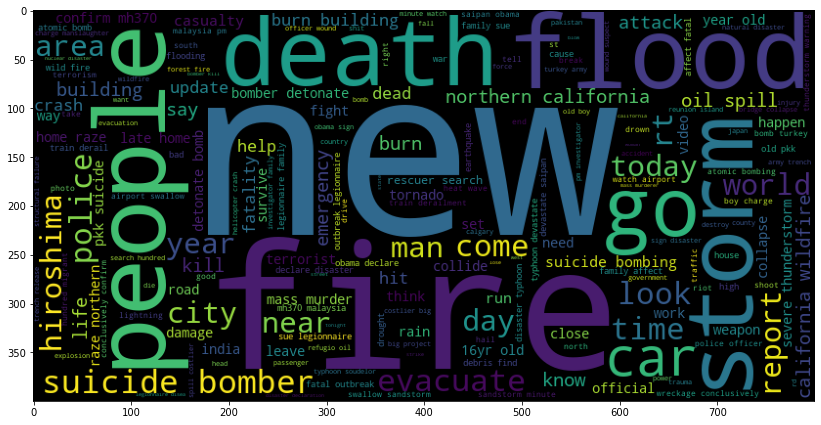

In [215]:
draw_cloud(join_twits(data, 1))

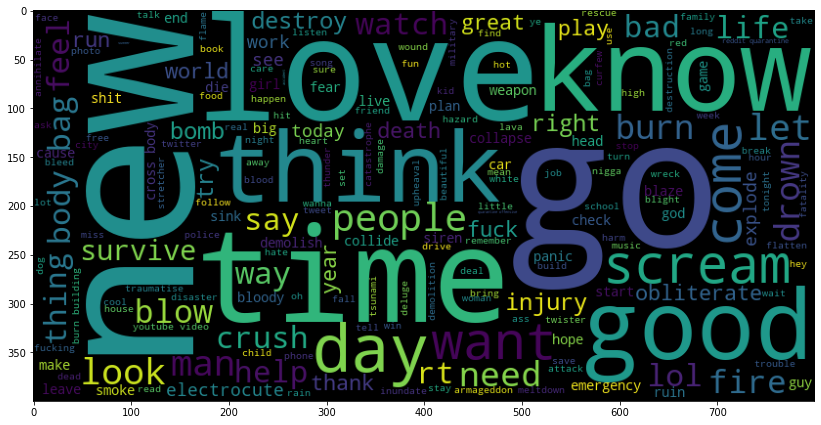

In [216]:
draw_cloud(join_twits(data, 0))

In [217]:
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
# TruncatedSVD from sklearn
from sklearn.decomposition import TruncatedSVD

In [218]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english', smooth_idf=True)
X = vectorizer.fit_transform(data['text_ready'])
dense = X.toarray()
dense

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [219]:
it = iter(dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])))
for i in range(10):
    print(next(it))

00
000
0000
00pm
01
02
0215
02pm
03
030


In [220]:
dense.shape

(7613, 14517)

In [221]:
data_idf = pd.DataFrame(dense, columns=[x for x in vectorizer.get_feature_names()])
data_idf

,00,000,0000,00pm,01,02,0215,02pm,03,030,033,034,039,04,05,05th,06,060,061,06jst,07,08,0840728,0853,087809233445,0880,09,10,100,1000,10000,100000,1000s,1008pla,1008planet,100bn,100nd,101,1017,1023,...,zenande,zenit,zeno001,zepp1978,zergele,zero,zhejiang,zhenghxn,zicac,zimbabwe,zimmer,zimmerman,zimpapersviews,zionism,zionist,zip,ziphimup,zippednew,zippednews,zipper,zippoline,ziuw,zmne,zodiac,zojadelin,zomatoaus,zombie,zombiefunrun2014,zone,zonewolf123,zoom,zotar,zouma,zourryart,zrnf,zss,zumiez,zurich,zxathetis,zzzz
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7609,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7610,0.0,0.0,0.0,0.0,0.340454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.361315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7611,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [229]:
word_count = list()
words = data_idf.columns.to_list()
word_count = [(data_idf[c] !=0.0).sum() for c in data_idf.columns]

In [234]:
data_wcounts = pd.DataFrame(zip(words,word_count), columns=['word', 'count'])


In [243]:
#data_idf['token'] = data_idf.index
data_wcounts[data_wcounts['count']>1].sort_values(by='count', ascending=False)[:15]

,word,count
7677,like,377
8979,new,227
9778,people,196
8991,news,191
2250,burn,168
13753,video,167
7265,kill,164
14379,year,164
1969,bomb,164
2992,come,158


In [244]:
import plotly.express as px

# Create bar chart
fig = px.bar(data_wcounts.sort_values(by='count', ascending=False)[:15], x="word", y='count')

# Render chart
fig.show()

In [ ]:
from collections import Counter
word_freq = Counter(vectorizer.vocabulary_)